# Defensive Distillation of Cloud AutoAI Models

In this notebook, we defensively distil the cloud AutoAI models trained on MNIST to a LeNet-type model, in the hopes of achieving adversarial robustness. For training the distilled model, we use the softmax predictions of the GCP AutoML model and the IBMCloud AutoAI model on 80% of the MNIST test data. We then test the resulting distilled model on our adversarial examples, along with the remainder of the test set.

Reference code:
 https://github.com/hiaghosh/Defensive-Distillation/blob/master/models/mnist/mnist.py
 https://keras.io/examples/vision/knowledge_distillation/

In [29]:
import keras
from keras.models import Sequential
from tensorflow.keras import optimizers
from keras.layers import Dense, Dropout, Flatten, Lambda
from keras.layers import Conv1D, MaxPooling1D

import tensorflow as tf
import pandas as pd
import numpy as np

## Distilling from GCP Model

In [2]:
train = pd.read_csv('gcp_distil_train.csv', sep=',', index_col=None)
train.head()

,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,label_1_score,label_7_score,label_3_score,label_0_score,label_2_score,label_6_score,label_4_score,label_8_score,label_9_score,label_5_score,Predicted_Label_String,Predicted_label
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000042,0.000059,0.000076,0.000058,0.000180,0.998739,0.000177,0.000276,0.000128,0.000266,label_6_score,6
1,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010941,0.005737,0.020158,0.000552,0.001144,0.000482,0.024135,0.027317,0.896730,0.012805,label_9_score,9
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004420,0.008049,0.879280,0.000828,0.001056,0.000939,0.001454,0.006095,0.019253,0.078626,label_3_score,3
3,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000139,0.001419,0.000451,0.000067,0.000091,0.000066,0.003475,0.000814,0.992655,0.000824,label_9_score,9
4,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000465,0.000677,0.001602,0.042420,0.005500,0.942992,0.001347,0.001039,0.000787,0.003172,label_6_score,6


In [3]:
train.columns

Index(['label', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       'label_3_score', 'label_0_score', 'label_2_score', 'label_6_score',
       'label_4_score', 'label_8_score', 'label_9_score', 'label_5_score',
       'Predicted_Label_String', 'Predicted_label'],
      dtype='object', length=797)

In [15]:
#Prepare Training Data
train_x_cols = train.columns[1:785]
train_y_cols = ['label_0_score','label_1_score','label_2_score','label_3_score','label_4_score', 'label_5_score', 'label_6_score','label_7_score','label_8_score','label_9_score']

x_train = train[train_x_cols]
y_train = train[train_y_cols]

In [16]:
x_train = x_train.values
y_train = y_train.values

In [27]:
#create Distilled Model
def createModel():
  model = Sequential()
  model.add((Conv1D(32, kernel_size=3, activation='relu', input_shape=(784,1))))
  model.add((Conv1D(32, kernel_size=1, activation='relu')))
  model.add(MaxPooling1D(pool_size=2))
  model.add((Conv1D(64, kernel_size=3, activation='relu')))
  model.add((Conv1D(64, kernel_size=3, activation='relu')))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(200, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(200, activation='relu'))
  model.add(Dense(10))
  return model

In [30]:
# train model
def temperature_cross_entropy(gt, pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=gt, logits=pred)
    return loss

model = createModel()
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=temperature_cross_entropy, optimizer=sgd, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
63/63 [==============================] - 12s 34ms/step - loss: 2.2677 - accuracy: 0.1692
Epoch 2/50
63/63 [==============================] - 2s 32ms/step - loss: 0.7764 - accuracy: 0.7602
Epoch 3/50
63/63 [==============================] - 2s 31ms/step - loss: 0.3587 - accuracy: 0.9252
Epoch 4/50
63/63 [==============================] - 2s 32ms/step - loss: 0.3057 - accuracy: 0.9503
Epoch 5/50
63/63 [==============================] - 2s 31ms/step - loss: 0.2824 - accuracy: 0.9613
Epoch 6/50
63/63 [==============================] - 2s 31ms/step - loss: 0.2658 - accuracy: 0.9655
Epoch 7/50
63/63 [==============================] - 2s 31ms/step - loss: 0.2621 - accuracy: 0.9684
Epoch 8/50
63/63 [==============================] - 2s 31ms/step - loss: 0.2529 - accuracy: 0.9728
Epoch 9/50
63/63 [==============================] - 2s 32ms/step - loss: 0.2473 - accuracy: 0.9739
Epoch 10/50
63/63 [==============================] - 2s 32ms/step - loss: 0.2407 - accuracy: 0.9781
Epoch 11

## Evaluate Distilled Model

In [49]:
#prepare testing data - On test set
test = pd.read_csv('gcp_distil_test.csv', sep=',', index_col=None)

test_x_cols = test.columns[1:785]
#test_y_cols = ['Predicted_label']
test_y_cols = ['label_0_score','label_1_score','label_2_score','label_3_score','label_4_score', 'label_5_score', 'label_6_score','label_7_score','label_8_score','label_9_score']


x_test = test[test_x_cols]
y_test = test[test_y_cols]
y_label = test['Predicted_label']

In [36]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Distilled Accuracy (On Test Set):\t{score[1]*100}')

Distilled Accuracy (On Test Set):	97.79005646705627


In [51]:
ad10 = pd.read_csv('adv_examples_10.csv', sep=',', index_col=None)
ad15 = pd.read_csv('adv_examples_15.csv', sep=',', index_col=None)
ad20 = pd.read_csv('adv_examples_20.csv', sep=',', index_col=None)
ad25 = pd.read_csv('adv_examples_25.csv', sep=',', index_col=None)
ad30 = pd.read_csv('adv_examples_30.csv', sep=',', index_col=None)

In [64]:
#Evaluate Adversarial Robustness of Distilled model
def adversarialAccuracy(model, adv_df, eps):
  y_label = adv_df['true_label']
  x_adv = adv_df.iloc[:,2:]
  logit_predictions = model.predict(x_adv)
  y_pred = np.array(list(map(np.argmax, logit_predictions)))
  correct = y_label == y_pred
  print("Accuracy (Epsilon = {}) : {}".format(eps,np.count_nonzero(correct)*100/correct.size))
  return

In [66]:
adversarialAccuracy(model, ad10, 0.10)
adversarialAccuracy(model, ad15, 0.15)
adversarialAccuracy(model, ad20, 0.20)
adversarialAccuracy(model, ad25, 0.25)
adversarialAccuracy(model, ad30, 0.30)

Accuracy (Epsilon = 0.1) : 75.6923076923077
Accuracy (Epsilon = 0.15) : 75.13404825737265
Accuracy (Epsilon = 0.2) : 52.33254674169541
Accuracy (Epsilon = 0.25) : 26.5527950310559
Accuracy (Epsilon = 0.3) : 18.141147522648474


## Distilling from IBM Cloud Model

In [69]:
train = pd.read_csv('ibm_distil_train.csv', sep=',', index_col=None)

In [70]:
#Prepare Training Data
train_x_cols = train.columns[1:785]
train_y_cols = ['label_0_score','label_1_score','label_2_score','label_3_score','label_4_score', 'label_5_score', 'label_6_score','label_7_score','label_8_score','label_9_score']

x_train = train[train_x_cols]
y_train = train[train_y_cols]
x_train = x_train.values
y_train = y_train.values

In [67]:
#create Distilled Model
def createModel():
  model = Sequential()
  model.add((Conv1D(32, kernel_size=3, activation='relu', input_shape=(784,1))))
  model.add((Conv1D(32, kernel_size=1, activation='relu')))
  model.add(MaxPooling1D(pool_size=2))
  model.add((Conv1D(64, kernel_size=3, activation='relu')))
  model.add((Conv1D(64, kernel_size=3, activation='relu')))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(200, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(200, activation='relu'))
  model.add(Dense(10))
  return model

In [71]:
# train model
def temperature_cross_entropy(gt, pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=gt, logits=pred)
    return loss

model = createModel()
sgd = optimizers.SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss=temperature_cross_entropy, optimizer=sgd, metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=128, epochs=50, verbose=0)

## Evaluate Distilled Model

In [72]:
#prepare testing data - On test set
test = pd.read_csv('gcp_distil_test.csv', sep=',', index_col=None)

test_x_cols = test.columns[1:785]
#test_y_cols = ['Predicted_label']
test_y_cols = ['label_0_score','label_1_score','label_2_score','label_3_score','label_4_score', 'label_5_score', 'label_6_score','label_7_score','label_8_score','label_9_score']


x_test = test[test_x_cols]
y_test = test[test_y_cols]
y_label = test['Predicted_label']

In [74]:
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Distilled Accuracy (On Test Set):\t{score[1]*100}')

Distilled Accuracy (On Test Set): 	 98.99011256371632


In [75]:
ad10 = pd.read_csv('adv_examples_10.csv', sep=',', index_col=None)
ad15 = pd.read_csv('adv_examples_15.csv', sep=',', index_col=None)
ad20 = pd.read_csv('adv_examples_20.csv', sep=',', index_col=None)
ad25 = pd.read_csv('adv_examples_25.csv', sep=',', index_col=None)
ad30 = pd.read_csv('adv_examples_30.csv', sep=',', index_col=None)

In [76]:
#Evaluate Adversarial Robustness of Distilled model
def adversarialAccuracy(model, adv_df, eps):
  y_label = adv_df['true_label']
  x_adv = adv_df.iloc[:,2:]
  logit_predictions = model.predict(x_adv)
  y_pred = np.array(list(map(np.argmax, logit_predictions)))
  correct = y_label == y_pred
  print("Accuracy (Epsilon = {}) : {}".format(eps,np.count_nonzero(correct)*100/correct.size))
  return

In [83]:
adversarialAccuracy(model, ad10, 0.10)
adversarialAccuracy(model, ad15, 0.15)
adversarialAccuracy(model, ad20, 0.20)
adversarialAccuracy(model, ad25, 0.25)
adversarialAccuracy(model, ad30, 0.30)

Accuracy (Epsilon = 0.1) : 74.1935739227174
Accuracy (Epsilon = 0.15) : 68.6451482271437618
Accuracy (Epsilon = 0.2) : 49.98151689462019
Accuracy (Epsilon = 0.25) : 20.45129401175791
Accuracy (Epsilon = 0.3) : 19.0001471286989701


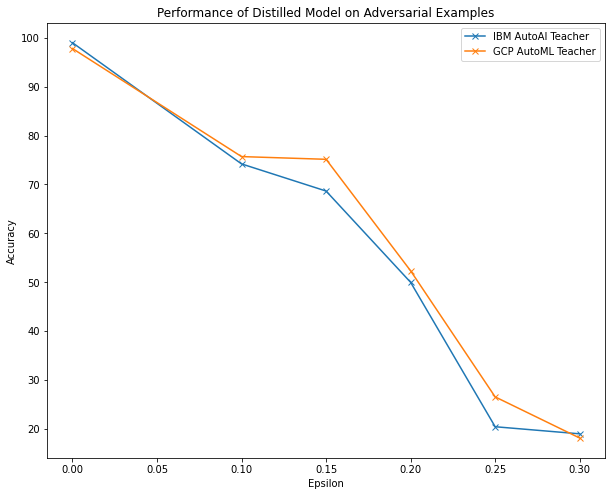

In [88]:
# Make Graph
import matplotlib.pyplot as plt

epsilons = [0,0.10,0.15,0.20,0.25,0.30]
ibm_acc = [98.98, 74.193, 68.645, 49.981,20.451,19]
gcp_acc = [97.79,75.690,75.134,52.332, 26.552, 18.141]

fig = plt.figure(figsize = (10,8))
plt.plot(epsilons, ibm_acc, marker='x', label='IBM AutoAI Teacher')
plt.plot(epsilons, gcp_acc, marker='x', label='GCP AutoML Teacher')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Performance of Distilled Model on Adversarial Examples')
plt.legend()
plt.savefig('distillation.png')
plt.show()


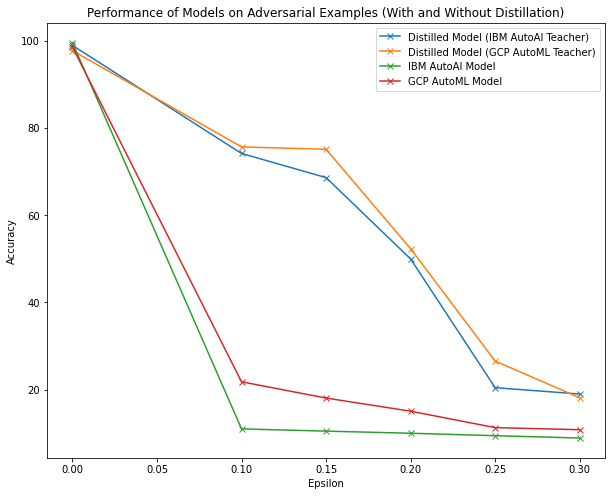

In [89]:
# Make Graph
import matplotlib.pyplot as plt

epsilons = [0,0.10,0.15,0.20,0.25,0.30]
ibm_dist_acc = [98.98, 74.193, 68.645, 49.981,20.451,19]
gcp_dist_acc = [97.79,75.690,75.134,52.332, 26.552, 18.141]
ibm_acc = [99.6, 11.002, 10.489,10.001, 9.441, 8.903]
gcp_acc = [98.6,21.806, 18.073, 15.062, 11.290,10.812]

fig = plt.figure(figsize = (10,8))
plt.plot(epsilons, ibm_dist_acc, marker='x', label='Distilled Model (IBM AutoAI Teacher)')
plt.plot(epsilons, gcp_dist_acc, marker='x', label='Distilled Model (GCP AutoML Teacher)')
plt.plot(epsilons, ibm_acc, marker='x', label='IBM AutoAI Model')
plt.plot(epsilons, gcp_acc, marker='x', label='GCP AutoML Model')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Performance of Models on Adversarial Examples (With and Without Distillation)')
plt.legend()
plt.savefig('adv_robustness.png')
plt.show()
